In [2]:
import pandas as pd 
import os 
from tqdm import tqdm
import json
import torch
import torch.nn as nn
"""
This program converts the multiple MIMIC-IV-ED files into one large dataframe
"""



/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\nThis program converts the multiple MIMIC-IV-ED files into one large dataframe\n'

In [6]:
print("Loading ED Stays")
bucket_name = "chianglab-rawdata"
valid_dispositions = [
    'HOME', # 241632
    'ADMITTED', #158010
    'TRANSFER', # 7025
    # 'LEFT WITHOUT BEING SEEN', #6155
    # 'ELOPED', #5710
    # 'OTHER',  #4297
    # 'LEFT AGAINST MEDICAL ADVICE', #1881
    # 'EXPIRED' #377
]
file_path = "mimic-iv-ed-2.2/ed/edstays.csv.gz"
data_location = 's3://{}/{}'.format(bucket_name, file_path)
edstays = pd.read_csv(data_location)
# edstays = edstays[edstays['disposition']]#.isin(valid_dispositions)]
display(edstays)

# file_path = "mimic-iv-ed-2.2/ed/triage.csv.gz"
# data_location = 's3://{}/{}'.format(bucket_name, file_path)
# triage = pd.read_csv(data_location)
# display(triage)

# print('loading medrecon')
# file_path = "mimic-iv-ed-2.2/ed/medrecon.csv.gz"
# data_location = 's3://{}/{}'.format(bucket_name, file_path)
# medrecon = pd.read_csv(data_location)

# display(medrecon)


# print('loading pyxis')
# file_path = "mimic-iv-ed-2.2/ed/pyxis.csv.gz"
# data_location = 's3://{}/{}'.format(bucket_name, file_path)
# pyxis = pd.read_csv(data_location)
# display(pyxis)
    

# print('loading diagnosis')
# file_path = "mimic-iv-ed-2.2/ed/diagnosis.csv.gz"
# data_location = 's3://{}/{}'.format(bucket_name, file_path)
# diagnosis = pd.read_csv(data_location)
# display(diagnosis)
edstays["disposition"].value_counts()

Loading ED Stays


,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED
...,...,...,...,...,...,...,...,...,...
425082,19999784,26194817.0,35692999,2119-06-18 14:21:00,2119-06-18 21:09:29,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED
425083,19999828,25744818.0,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,F,WHITE,AMBULANCE,ADMITTED
425084,19999828,29734428.0,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED
425085,19999914,NaN,32002659,2158-12-24 11:41:00,2158-12-24 11:56:00,F,UNKNOWN,UNKNOWN,ELOPED


HOME                           241632
ADMITTED                       158010
TRANSFER                         7025
LEFT WITHOUT BEING SEEN          6155
ELOPED                           5710
OTHER                            4297
LEFT AGAINST MEDICAL ADVICE      1881
EXPIRED                           377
Name: disposition, dtype: int64

In [22]:
diagnosis["icd_title"] = diagnosis["icd_title"].str.lower()
counts = diagnosis["icd_title"].value_counts()
temp = diagnosis[diagnosis["icd_title"].map(counts)>100]
len(temp["icd_title"].value_counts())

hypertension nos                                              26816
essential (primary) hypertension                              21264
chest pain, unspecified                                       13016
headache                                                      12894
chest pain nos                                                12398
                                                              ...  
pneumonitis due to inhalation of other solids and liquids         1
driver of special industrial vehicle injured nontraf, init        1
ischemic cardiomyopathy                                           1
injury palmar artery                                              1
nondisp fx of proximal phalanx of l thm, init for opn fx          1
Name: icd_title, Length: 12883, dtype: int64


991

In [39]:
# drop subject id
print("Dropping subject ID")
dataframes_ = [edstays,triage, medrecon, pyxis, diagnosis]

for j in range(len(dataframes_)):
    df = dataframes_[j]
    if 'subject_id' in df.columns:
        df.drop('subject_id', axis=1, inplace=True)
        
# Start by fixing Triage
print("data quality on triage")
# Filter columns with missing values (NAs)
missing_values = triage.isna().sum()

# Filter columns with missing values (NAs)
columns_with_missing_values = missing_values[missing_values > 0]

if not columns_with_missing_values.empty:
    print("Columns with missing values (NAs) and their data types:")
    for column_name in columns_with_missing_values.index:
        data_type = triage[column_name].dtype
        if data_type == float:
            median_value = triage[column_name].median()
            triage[column_name].fillna(median_value, inplace=True)
            
        else:
            #just for this one value for pain
            mode_value = triage[column_name].mode()
            triage[column_name].fillna(0, inplace=True)
            
else:
    print("No columns have missing values (NAs).")

print("data quality on pyxis")
pyxis = pyxis[['stay_id', 'name']]
missing_values = pyxis.isna().sum()
columns_with_missing_values = missing_values[missing_values > 0]

if not columns_with_missing_values.empty:
    print("Columns with missing values (NAs) and their data types:")
    for column_name in columns_with_missing_values.index:
        data_type = pyxis[column_name].dtype
        if data_type == float:
            median_value = pyxis[column_name].median()
            pyxis[column_name].fillna(median_value, inplace=True)
            
        else:
            #just for this one value for pain
            mode_value = pyxis[column_name].mode()
            pyxis[column_name].fillna(0, inplace=True)
            
else:
    print("No columns have missing values (NAs).")

pyxis_grouped = pyxis.groupby(['stay_id']).sum().reset_index()


unique_stay_ids = pyxis_grouped['stay_id'].nunique()
print(f'The number of unique ids in the pyxis DataFrame is: {unique_stay_ids}')

print("qc in medrecon")

medrecon = medrecon[['stay_id', 'name']]
missing_values = medrecon.isna().sum()
columns_with_missing_values = missing_values[missing_values > 0]

if not columns_with_missing_values.empty:
    print("Columns with missing values (NAs) and their data types:")
    for column_name in columns_with_missing_values.index:
        data_type = medrecon[column_name].dtype
        if data_type == float:
            median_value = medrecon[column_name].median()
            medrecon[column_name].fillna(median_value, inplace=True)
            
        else:
            #just for this one value for pain
            mode_value = medrecon[column_name].mode()
            medrecon[column_name].fillna(0, inplace=True)
            
else:
    print("No columns have missing values (NAs).")

#medrecon = pd.get_dummies(medrecon, columns=['name'], drop_first=True)
medrecon_grouped = medrecon.groupby(['stay_id']).sum().reset_index()


unique_stay_ids = medrecon_grouped['stay_id'].nunique()
print(f'The number of unique medrecon in the medrecon DataFrame is: {unique_stay_ids}')

print("qc in diagnosis")
# Lastly Fix diagnosis
diagnosis = diagnosis[['stay_id', 'icd_title']]

missing_values = diagnosis.isna().sum()
columns_with_missing_values = missing_values[missing_values > 0]

if not columns_with_missing_values.empty:
    print("Columns with missing values (NAs) and their data types:")
    for column_name in columns_with_missing_values.index:
        data_type = diagnosis[column_name].dtype
        if data_type == float:
            median_value = diagnosis[column_name].median()
            diagnosis[column_name].fillna(median_value, inplace=True)
            
        else:
            #just for this one value for pain
            mode_value = diagnosis[column_name].mode()
            diagnosis[column_name].fillna(0, inplace=True)
            
else:
    print("No columns have missing values (NAs).")
#diagnosis = pd.get_dummies(diagnosis, columns=['icd_title'], drop_first=True)
diagnosis_grouped = diagnosis.groupby(['stay_id']).sum().reset_index()
unique_stay_ids = diagnosis_grouped['stay_id'].nunique()

print(f'The number of unique stay_ids in the diagnosis DataFrame is: {unique_stay_ids}')

print("add ed disposition")
#fix edstayabss

edstays = edstays[['stay_id', 'disposition']]
edstays['disposition'].nunique()
value_mapping = {'ADMITTED': 0, 'HOME': 1}

# Use the replace() function to map values in the 'disposition' column
edstays['disposition'] = edstays['disposition'].replace(value_mapping)

print("merge")
dfs_to_merge = [edstays, triage, diagnosis_grouped, medrecon_grouped, pyxis_grouped]
merged_df = pd.merge(edstays, triage, on='stay_id', how='inner')
for dfs in dfs_to_merge[2:]:
    merged_df = pd.merge(merged_df, dfs, on='stay_id', how='inner')
merged_df

Dropping subject ID
data quality on triage
Columns with missing values (NAs) and their data types:


In [40]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the 'Category' column
merged_df['icd_title'] = label_encoder.fit_transform(merged_df['icd_title'])
merged_df['name_x'] = label_encoder.fit_transform(merged_df['name_x'])
merged_df['name_y'] = label_encoder.fit_transform(merged_df['name_y'])
merged_df = merged_df.drop("chiefcomplaint",axis=1)
model_df = merged_df.drop('stay_id', axis=1)
model_df = model_df[pd.to_numeric(model_df['pain'], errors='coerce').notnull()]
model_df["pain"] = model_df['pain'].astype('float64')
labels = model_df['disposition']
features = model_df.drop('disposition', axis = 1)
features

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,icd_title,name_x,name_y
0,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,57955,83488,81516
1,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,17079,157430,80139
2,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,41855,83478,13784
3,98.7,77.0,16.0,98.0,96.0,50.0,13.0,2.0,5596,83478,58925
4,97.5,78.0,16.0,100.0,114.0,71.0,0.0,2.0,92115,172737,105819
...,...,...,...,...,...,...,...,...,...,...,...
222596,98.0,60.0,18.0,100.0,120.0,71.0,0.0,3.0,57819,176664,36586
222597,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,50459,176952,61950
222598,98.8,92.0,18.0,100.0,122.0,77.0,0.0,3.0,61305,32374,72071
222599,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0,84187,70533,104457


In [23]:
model_df = merged_df.drop('stay_id', axis=1)
labels = model_df['disposition']
features = model_df.drop('disposition', axis = 1)
features = features[pd.to_numeric(features['pain'], errors='coerce').notnull()]
features = features['pain'].astype('float64')


In [ ]:
import torch
import cudf
from cuml.ensemble import RandomForestClassifier
from cuml.preprocessing.model_selection import train_test_split

ModuleNotFoundError: No module named 'cuml'

In [41]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2)

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier().to(device)
# Train the model on training data
rf.fit(train_features.to(device), train_labels.to(device));

AttributeError: 'RandomForestClassifier' object has no attribute 'to'

In [483]:
predicted_labels = rf.predict(test_features)

# Assuming test_labels is the actual labels for your test data
# Calculate the accuracy or any other relevant evaluation metric
# For classification tasks, you can use metrics like accuracy, precision, recall, F1-score, etc.
from sklearn.metrics import accuracy_score

# Compare predicted_labels with test_labels
accuracy = accuracy_score(test_labels, predicted_labels)

# Print the accuracy or other evaluation metric
print("Accuracy:", accuracy)

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Calculate AUC
auc_score = roc_auc_score(test_labels, predicted_labels)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, predicted_labels)

# Calculate the area under the Precision-Recall curve
pr_auc = auc(recall, precision)

# Print the AUC and Precision-Recall AUC
print("AUC:", auc_score)
print("Precision-Recall AUC:", pr_auc)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Accuracy: 0.6785714285714286
AUC: 0.5
Precision-Recall AUC: 0.6607142857142857


,disposition,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,pain_0,pain_10,...,name_y_Sodium Chloride 0.9% (Mini Bag Plus)Pantoprazole SodiumCefTRIAXoneCefTRIAXonePantoprazole SodiumOctreotide AcetateOctreotide Acetate,name_y_Sulfameth/Trimeth DSSulfameth/Trimeth DSCephalexinAcetaminophen,name_y_Tetanus-DiphTox-Acellular PertussTetanus-DiphTox-Acellular PertussTetanus-DiphTox-Acellular Pertuss,name_y_Vancomyci 1000mg/200mL 200mL BAGVancomyci 1000mg/200mL 200mL BAG,name_y_VancomycinInsulin Human RegularVancomycin,name_y_VancomycinVancomycin,name_y_VancomycinVancomycinAcetaminophen (Rectal),name_y_VancomycinVancomycinLevofloxacinAcetaminophen (Rectal),name_y_VancomycinVancomycinLevofloxacinMetRONIDAZOLE (Flagyl),name_y_VancomycinVancomycinMetRONIDAZOLE (Flagyl)Ciprofloxacin IVInsulin Human RegularInsulin Human RegularInsulin Human Regular
0,0,99.1,90.0,26.0,98.0,86.0,61.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,96.2,74.0,18.0,100.0,142.0,75.0,2.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,99.2,130.0,32.0,94.0,106.0,74.0,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,97.5,118.0,18.0,96.0,100.0,56.0,2.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,98.1,89.0,18.0,96.0,131.0,90.0,3.0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0,97.6,116.0,14.0,99.0,140.0,78.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,0,99.0,87.0,18.0,96.0,126.0,68.0,3.0,1,0,...,0,0,0,0,0,0,0,0,0,0
136,0,97.6,103.0,16.0,98.0,138.0,72.0,2.0,1,0,...,0,0,0,0,0,0,0,0,0,0
137,0,98.0,90.0,18.0,98.0,135.0,72.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


Empty DataFrame
Columns: [stay_id, disposition]
Index: []


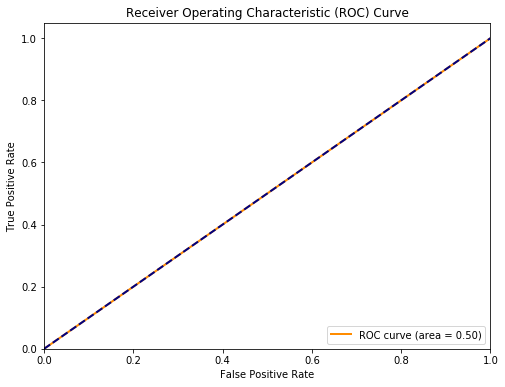

In [471]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have test_labels and predicted_labels from your model

# Calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels, predicted_labels)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [472]:
from torch.utils.data import Dataset, DataLoader, random_split, default_collate


input_dim = 539
num_labels = 2
model = SelfAttentionPlus(input_dim)

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.float32).reshape(-1, 1)
test_features_tensor = torch.tensor(test_features.values, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.float32).reshape(-1, 1)



class Model_Dataset(Dataset):
    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target
    
training_dataset = Model_Dataset(train_features_tensor, train_labels_tensor)
test_dataset = Model_Dataset(test_features_tensor, test_labels_tensor)
loader = DataLoader(training_dataset, shuffle=True, batch_size=100)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [473]:
import torch.nn as nn
 
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(539, 539)
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(539, 128)
        self.relu = nn.ReLU()
        self.hidden3 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.sigmoid(self.output(x))
        return x

In [477]:
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)


n_epochs = 100
model1 = Wide()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        y_pred = model1(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')
    


Finished epoch 0, latest loss 0.699717104434967
Finished epoch 1, latest loss 0.699717104434967
Finished epoch 2, latest loss 0.699717104434967
Finished epoch 3, latest loss 0.699717104434967
Finished epoch 4, latest loss 0.699717104434967
Finished epoch 5, latest loss 0.699717104434967
Finished epoch 6, latest loss 0.699717104434967
Finished epoch 7, latest loss 0.699717104434967
Finished epoch 8, latest loss 0.699717104434967
Finished epoch 9, latest loss 0.699717104434967
Finished epoch 10, latest loss 0.699717104434967
Finished epoch 11, latest loss 0.699717104434967
Finished epoch 12, latest loss 0.699717104434967
Finished epoch 13, latest loss 0.699717104434967
Finished epoch 14, latest loss 0.699717104434967
Finished epoch 15, latest loss 0.699717104434967
Finished epoch 16, latest loss 0.699717104434967
Finished epoch 17, latest loss 0.699717104434967
Finished epoch 18, latest loss 0.699717104434967
Finished epoch 19, latest loss 0.699717104434967
Finished epoch 20, latest loss

In [478]:
X_test, y_test = default_collate(test_dataset)
model1.eval()
y_pred = model1(X_test)
acc = (y_pred.round() == y_test).float().mean()
acc = float(acc)
print("Model accuracy: %.2f%%" % (acc*100))

Model accuracy: 50.00%


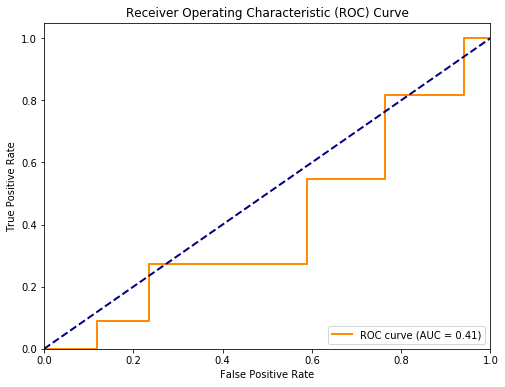

In [479]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have your test_features_tensor and test_labels_tensor as defined in your code

# Make predictions using your model
with torch.no_grad():
    y_pred_prob = model1(test_features_tensor).numpy()

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels_tensor, y_pred_prob)

# Compute the ROC AUC (Area Under the Curve) score
roc_auc = roc_auc_score(test_labels_tensor, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [465]:
model_df[['disposition', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity']]


,disposition,heartrate,resprate,o2sat,sbp,dbp,acuity
0,0,90.0,26.0,98.0,86.0,61.0,1.0
1,1,74.0,18.0,100.0,142.0,75.0,2.0
2,0,130.0,32.0,94.0,106.0,74.0,1.0
3,0,118.0,18.0,96.0,100.0,56.0,2.0
4,1,89.0,18.0,96.0,131.0,90.0,3.0
...,...,...,...,...,...,...,...
134,0,116.0,14.0,99.0,140.0,78.0,3.0
135,0,87.0,18.0,96.0,126.0,68.0,3.0
136,0,103.0,16.0,98.0,138.0,72.0,2.0
137,0,90.0,18.0,98.0,135.0,72.0,1.0
